In [1]:
# Imports
import os
import glob
import re
from concurrent.futures import ThreadPoolExecutor

In [2]:
import pandas as pd
import numpy as np
import json
import torch
import matplotlib.pyplot as plt
import networkx as nx
from PIL import Image  # For image processing
from IPython.display import display  # For displaying images in Jupyter
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [3]:
import transformers
from transformers import pipeline

In [4]:
import open_clip


In [5]:
from open_clip import create_model_from_pretrained, get_tokenizer # For BiomedCLIP model
from transformers import AutoTokenizer, AutoModel # For BioLinkBERT model
from sentence_transformers import SentenceTransformer # For MPNet model

In [3]:
# Uploading a csv file to a pandas DataFrame
def upload_csv(file_path):
    df = pd.read_csv(file_path)
    return df

In [6]:
file_path = '/cs/labs/tomhope/yuvalbus/pmc/pythonProject/data2/final_csv2.csv'
df = upload_csv(file_path)

len(df)

188516

In [14]:
df['contains_specified_patterns'] = df['caption_text'].apply(lambda caption : is_containing_specified_patterns(caption, patterns))

In [22]:
compound_images_df = df[df['contains_specified_patterns'] == True]

In [25]:
compound_images_dict = compound_images_df.to_dict(orient='records')  # or 'index', 'split', etc.
with open(r'/cs/labs/tomhope/yuvalbus/pmc/pythonProject/largeListsGuy/compound_images_df.json', 'w') as f:
    json.dump(compound_images_dict, f, indent=2)


In [ ]:
compound_images_dict[0]

{'image_path': 'PMC4827643/4827643_1/4827643_1_1.jpg',
 'caption_path': 'PMC4827643/4827643_1/4827643_1_1.txt',
 'patient_uid': '4827643-1',
 'pmc_id': 4827643,
 'article_path': 'https://ncbi.nlm.nih.gov/pmc/articles/PMC4827643',
 'unique_articles_sim_patients': "['5781267-1', '7278299-1']",
 'caption_text': 'Imaging of intracystic papillary carcinoma. A) Mammogram shows a 3.4 cm round nodular density in the right breast. B) Ultrasound shows a complex cystic and solid mass.',
 'contains_specified_patterns': True}

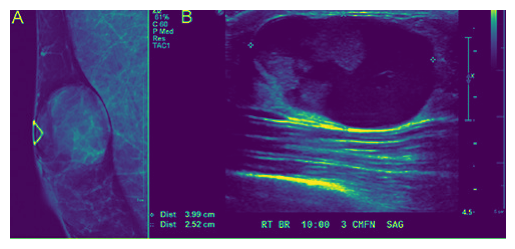

In [21]:
img_path = '/cs/labs/tomhope/yuvalbus/pmc/pythonProject/data2/PMC4827643/4827643_1/4827643_1_1.jpg'
img = Image.open(img_path)

plt.imshow(img)
plt.axis('off')  # Optional: hides the axes
plt.show()


In [9]:
# Adding a 'caption_text' column to the DataFrame which extracts the captions from the txt file
# Done in parallel in order to speed up the process
def read_caption(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            return f.read()
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return ""

def read_captions_parallel(paths, max_workers=8):
    captions = [None] * len(paths)
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_index = {executor.submit(read_caption, path): idx for idx, path in enumerate(paths)}
        for future in future_to_index:
            idx = future_to_index[future]
            try:
                captions[idx] = future.result()
            except Exception as e:
                print(f"Error reading caption at index {idx}: {e}")
                captions[idx] = ""
    return captions

In [8]:
def creating_uids_pairs(df, rows_num):
    matching_uids = []
    checked_pairs = set()
    # Create a set of patient_uids present in the filtered DataFrame
    uids_in_df = set(df['patient_uid'])
    
    for index, row in df.head(rows_num).iterrows():
        patient_uid = row['patient_uid']
        
        # # Ensure that patient_uid is in uids_in_df
        # if patient_uid not in uids_in_df:
        #     continue  # This should not happen, but added for safety

        sim_patients = row['unique_articles_sim_patients']
    
        # Skip NaN values
        if pd.isna(sim_patients):
            continue
    
        # Clean the 'unique_articles_sim_patients' column
        sim_patients = sim_patients.strip("[]").replace("'", "")
        sim_patients_list = sim_patients.split(', ') if sim_patients else []
    
        for similar_uid in sim_patients_list:
            # Skip self-matching
            if similar_uid == patient_uid:
                continue

            # Check if similar_uid is in the filtered DataFrame
            if similar_uid not in uids_in_df:
                continue  # Skip if similar_uid not in the DataFrame

            # Create a sorted tuple to handle symmetry
            pair = tuple(sorted([patient_uid, similar_uid]))
    
            # Check if the pair was already added
            if pair not in checked_pairs:
                matching_uids.append([patient_uid, similar_uid])  # Add the pair
                checked_pairs.add(pair)  # Mark this pair as checked

    return matching_uids


In [47]:
matching_uids[0:3]

[['8167975-1', '5563556-1'],
 ['4647049-1', '5654233-1'],
 ['4647049-1', '4142379-1']]

In [21]:
# Uploading the csv
file_path = '/cs/labs/tomhope/yuvalbus/pmc/pythonProject/data2/final_csv2.csv'
df = upload_csv(file_path)

In [22]:
# Uploading the filtered df (assuming filtering using regex was already called)
filtered_csv_path = r'/cs/labs/tomhope/dhtandguy21/envs/pmc_project/21_sep_filtered_data.csv'
filtered_df = pd.read_csv(filtered_csv_path)

In [26]:
df.head(2)

,image_path,caption_path,patient_uid,pmc_id,article_path,unique_articles_sim_patients
0,PMC8167975/8167975_1/8167975_1_1.jpg,PMC8167975/8167975_1/8167975_1_1.txt,8167975-1,8167975,https://ncbi.nlm.nih.gov/pmc/articles/PMC8167975,['5563556-1']
1,PMC8167975/8167975_1/8167975_1_2.jpg,PMC8167975/8167975_1/8167975_1_2.txt,8167975-1,8167975,https://ncbi.nlm.nih.gov/pmc/articles/PMC8167975,['5563556-1']


In [23]:
filtered_df.head(3)

,image_path,caption_path,patient_uid,pmc_id,article_path,unique_articles_sim_patients,caption_text
0,PMC8167975/8167975_1/8167975_1_1.jpg,PMC8167975/8167975_1/8167975_1_1.txt,8167975-1,8167975,https://ncbi.nlm.nih.gov/pmc/articles/PMC8167975,['5563556-1'],"Fundus photograph showed a yellowish white, pe..."
1,PMC8167975/8167975_1/8167975_1_2.jpg,PMC8167975/8167975_1/8167975_1_2.txt,8167975-1,8167975,https://ncbi.nlm.nih.gov/pmc/articles/PMC8167975,['5563556-1'],B-scan demonstrated focal subretinal calcifica...
2,PMC8167975/8167975_1/8167975_1_3.jpg,PMC8167975/8167975_1/8167975_1_3.txt,8167975-1,8167975,https://ncbi.nlm.nih.gov/pmc/articles/PMC8167975,['5563556-1'],CT demonstrated a hyperdense choroidal plaque ...


In [24]:

# Add 'caption_id' and 'patient_uid' columns to 'filtered_df'
filtered_df['caption_id'] = filtered_df['caption_path'].apply(
    lambda x: os.path.splitext(os.path.basename(x))[0]
)

# Create the mapping from 'patient_uid' to a set of 'caption_id's
patient_uid_to_captions = filtered_df.groupby('patient_uid')['caption_id'].apply(set).to_dict()


In [25]:
filtered_df.head(3)

,image_path,caption_path,patient_uid,pmc_id,article_path,unique_articles_sim_patients,caption_text,caption_id
0,PMC8167975/8167975_1/8167975_1_1.jpg,PMC8167975/8167975_1/8167975_1_1.txt,8167975-1,8167975,https://ncbi.nlm.nih.gov/pmc/articles/PMC8167975,['5563556-1'],"Fundus photograph showed a yellowish white, pe...",8167975_1_1
1,PMC8167975/8167975_1/8167975_1_2.jpg,PMC8167975/8167975_1/8167975_1_2.txt,8167975-1,8167975,https://ncbi.nlm.nih.gov/pmc/articles/PMC8167975,['5563556-1'],B-scan demonstrated focal subretinal calcifica...,8167975_1_2
2,PMC8167975/8167975_1/8167975_1_3.jpg,PMC8167975/8167975_1/8167975_1_3.txt,8167975-1,8167975,https://ncbi.nlm.nih.gov/pmc/articles/PMC8167975,['5563556-1'],CT demonstrated a hyperdense choroidal plaque ...,8167975_1_3


In [28]:
patient_uid_to_captions['8167975-1']

{'8167975_1_1',
 '8167975_1_2',
 '8167975_1_3',
 '8167975_1_4',
 '8167975_1_5',
 '8167975_1_6',
 '8167975_1_7',
 '8167975_1_8',
 '8167975_1_9'}

In [36]:
pair = matching_uids[0]
pair

['8167975-1', '5563556-1']

In [39]:
uid =pair[0][:-2]
uid

'8167975'

In [44]:
patient_uid_to_captions.get(uid+'-1', set())

{'8167975_1_1',
 '8167975_1_2',
 '8167975_1_3',
 '8167975_1_4',
 '8167975_1_5',
 '8167975_1_6',
 '8167975_1_7',
 '8167975_1_8',
 '8167975_1_9'}

In [ ]:
def creating_txt_jpg_pairs(matching_uids, file_path, patient_uid_to_captions):
    # Each list consists of pairs containing the aligned files for each patient_uid
    pairs_text_list = []
    pairs_image_list = []
    not_found_counter = 0

    # Iterating over the pairs
    for pair in matching_uids:
        uids = [pair[0][:-2], pair[1][:-2]]
    
        pair_aligned_txt_files = []
        pair_aligned_jpg_files = []
    
        # Iterating over each patient_uid within the pair
        for uid in uids:
            # Construct the full path using the base_path parameter
            path = os.path.join(file_path, f'PMC{uid}/{uid}_1')
    
            # Check if the path exists
            if not os.path.exists(path):
                # print(f"Directory {path} does not exist.")
                not_found_counter += 1
                continue
    
            # Get all txt and jpg files within a single patient_uid
            txt_files = glob.glob(os.path.join(path, '*.txt'))
            jpg_files = glob.glob(os.path.join(path, '*.jpg'))

            # Get valid caption IDs for this patient_uid
            valid_caption_ids = patient_uid_to_captions.get(uid+'-1', set())

            # Create mappings: '5603015_1_1' -> '/path/to/5603015_1_1.txt'
            txt_files_dict = {os.path.splitext(os.path.basename(f))[0]: f for f in txt_files}
            jpg_files_dict = {os.path.splitext(os.path.basename(f))[0]: f for f in jpg_files}

            # Find common keys that are in the valid captions for this uid
            common_keys = set(txt_files_dict.keys()) & set(jpg_files_dict.keys()) & valid_caption_ids

            # Sort the paths to align txt and jpg files
            sorted_keys = sorted(common_keys)

            # Align txt and jpg files (within the same patient_uid)
            aligned_txt_files = [txt_files_dict[key] for key in sorted_keys]
            aligned_jpg_files = [jpg_files_dict[key] for key in sorted_keys]

            # Append the aligned files for this patient_uid to the pair's list
            pair_aligned_txt_files.append(aligned_txt_files)
            pair_aligned_jpg_files.append(aligned_jpg_files)
    
        # After processing both patient_uids in the pair, append the pair to the main list
        if len(pair_aligned_txt_files) == 2:
            pairs_text_list.append(pair_aligned_txt_files)
            pairs_image_list.append(pair_aligned_jpg_files)
    
    return pairs_text_list, pairs_image_list, not_found_counter


In [7]:
# Checking whether a caption contains certain patterns
def is_containing_specified_patterns(caption, patterns):
    for pattern in patterns:
        if re.search(pattern, caption):
            return True
    return False

In [ ]:
# Filtering out the specified patterns using Regex
def filter_out_using_regex(df, patterns, csv_path_and_name):
    # Applying the function to the 'caption_text' column
    df['contains_specified_patterns'] = df['caption_text'].apply(lambda caption : is_containing_specified_patterns(caption, patterns))
    
    # Creating a new DataFrame that excludes rows with specified patterns
    df_filtered = df[~df['contains_specified_patterns']].reset_index(drop=True)

    # Dropping the 'contains_specified_patterns' column
    df_filtered = df_filtered.drop('contains_specified_patterns', axis='columns')
    
    # Saving the filtered DataFrame as a CSV file
    df_filtered.to_csv(csv_path_and_name, index=False)

    # Returning the newly saved DataFrame from the CSV`
    return pd.read_csv(csv_path_and_name)


In [ ]:
# Comment the next line for less detailed view of DataFrames
pd.set_option('display.max_colwidth', None)

In [13]:
patterns = [
    r'\(B\)',    # Matches (B)
    r'\(b\)',    # Matches (b)
    r'B\)',      # Matches B)
    r'b\)',      # Matches b)
    r'B\.',      # Matches B.
    r'b\.',      # Matches b.
    r'b\s[A-Z]',   # Matches 'b' followed by a space and a capital letter
    r'B\s[A-Z]',   # Matches 'B' followed by a space and a capital letter
]

In [11]:
# Read captions into 'caption_text' column
txt_paths = ['/cs/labs/tomhope/yuvalbus/pmc/pythonProject/data2/'+ elem for elem in df['caption_path'].tolist()]
df['caption_text'] = read_captions_parallel(txt_paths)

In [ ]:
df.tail(2)

In [ ]:
filtered_df = filter_out_using_regex(df, patterns, filtered_csv_path)

In [ ]:
filtered_df.tail(5)

In [ ]:
matching_uids = creating_uids_pairs(filtered_df, len(filtered_df))

In [48]:
len(matching_uids)

31692

In [49]:
lists_path = '/cs/labs/tomhope/yuvalbus/pmc/pythonProject/largeListsGuy/'

with open(lists_path + 'matching_uids.json', 'r') as f:
    matching_uids = json.load(f)

with open(lists_path + 'updated_matching_uids.json', 'r') as f:
    updated_matching_uids = json.load(f)


In [51]:
matching_uids == updated_matching_uids

True

In [ ]:
base_path = '/cs/labs/tomhope/yuvalbus/pmc/pythonProject/data2'
pairs_text_list, pairs_image_list, not_exist_num = creating_txt_jpg_pairs(matching_uids, base_path, patient_uid_to_captions)

In [ ]:
# Saving the lists to a json file
lists_path = r'/cs/labs/tomhope/dhtandguy21/envs/pmc_project/'

with open(lists_path + 'matching_uids.json', 'w') as f:
    json.dump(matching_uids, f)

with open(lists_path + 'pairs_text_list.json', 'w') as g:
    json.dump(pairs_text_list, g)

with open(lists_path + 'pairs_image_list.json', 'w') as h:
    json.dump(pairs_image_list, h)

In [35]:
# Loading the lists from a json file
lists_path = '/cs/labs/tomhope/yuvalbus/pmc/pythonProject/largeListsGuy/'

with open(lists_path + 'matching_uids.json', 'r') as f:
    matching_uids = json.load(f)

with open(lists_path + 'pairs_text_list.json', 'r') as g:
    pairs_text_list = json.load(g)

with open(lists_path + 'pairs_image_list.json', 'r') as h:
    pairs_image_list = json.load(h)

In [ ]:
def subgroup_pairs_imgs_txt(begin, end):
    return pairs_text_list[begin:end], pairs_image_list[begin:end]

In [ ]:
txt_subgroup_pairs, img_subgroup_pairs = subgroup_pairs_imgs_txt(0, 3000)

In [ ]:
txt_subgroup_pairs[55]

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

In [ ]:
# This function is designated to compute textual embeddings based on a pre-chosen model
def compute_textual_embeddings(captions_paths, text_model_type):
    captions = read_captions_parallel(captions_paths)
    
    if text_model_type == 'biomedclip':
        tokens = tokenizer(captions).to(device)
        # Disable gradient computation to optimize memory usage
        with torch.no_grad():
            text_ftrs = model.encode_text(tokens)
                
    elif text_model_type == 'biolinkbert':
        inputs = tokenizer(
            captions,
            max_length=512,
            padding=True,
            truncation=True,
            return_tensors="pt"
        ).to(device)
        with torch.no_grad():
            model_output = model(**inputs)
            # Obtain the token embeddings from the last hidden state
            token_embeddings = model_output.last_hidden_state  # Shape: [batch_size, seq_len, hidden_dim]
            # Create an attention mask
            attention_mask = inputs['attention_mask'].unsqueeze(-1).expand(token_embeddings.size()).float()
            # Perform mean pooling
            sum_embeddings = torch.sum(token_embeddings * attention_mask, dim=1)
            sum_mask = torch.clamp(attention_mask.sum(dim=1), min=1e-9)
            text_ftrs = sum_embeddings / sum_mask  # Shape: [batch_size, hidden_dim]


    elif text_model_type == 'mpnet':
        with torch.no_grad():
            text_ftrs = model.encode(captions, convert_to_tensor=True, batch_size=32)
            
    else:
        raise ValueError("Invalid text_model_type. Can only accept one of the following: 'biomedclip', 'mpnet', 'biolinkbert'")

    return text_ftrs

In [ ]:
# Computing visual embeddings for a list of image paths
def compute_visual_embeddings(imgs_paths):
    imgs = [preprocess(Image.open(path)) for path in imgs_paths]
    imgs_batch = torch.stack(imgs).to(device)
    with torch.no_grad():
        imgs_ftrs = biomedclip_model.encode_image(imgs_batch)
    return imgs_ftrs

In [ ]:
# Concatenating normalized visual and textual embeddings
def concatenate_embeddings_1(imgs_ftrs, text_ftrs):
    # Normalize embeddings individually
    # imgs_ftrs_norm = imgs_ftrs / imgs_ftrs.norm(dim=1, keepdim=True)
    # text_ftrs_norm = text_ftrs / text_ftrs.norm(dim=1, keepdim=True)
    # Concatenate normalized embeddings
    # concat_ftrs = torch.cat((imgs_ftrs_norm, text_ftrs_norm), dim=1)
    concat_ftrs = torch.cat((imgs_ftrs, text_ftrs), dim=1)

    # Normalize concatenated embeddings
    concat_ftrs_norm = concat_ftrs / concat_ftrs.norm(dim=1, keepdim=True)
    return concat_ftrs_norm # Shape: [num_samples, 2 * feature_dim]


In [ ]:
# Define the function to concatenate normalized embeddings
def concatenate_embeddings_2(imgs_ftrs, text_ftrs):
    # Normalize embeddings individually (for concatenation purposes)
    imgs_ftrs_norm = imgs_ftrs / imgs_ftrs.norm(dim=1, keepdim=True)
    text_ftrs_norm = text_ftrs / text_ftrs.norm(dim=1, keepdim=True)

    # Compute cosine similarity for each pair of text and image embeddings
    cosine_text = torch.nn.functional.cosine_similarity(text_ftrs, text_ftrs, dim=0)
    cosine_visual = torch.nn.functional.cosine_similarity(imgs_ftrs, imgs_ftrs, dim=0)

    # Assign weights based on the cosine similarities
    weight_text = cosine_text / (cosine_text + cosine_visual)
    weight_visual = cosine_visual / (cosine_text + cosine_visual)

    # Apply weights to text and visual embeddings
    weighted_text_ftrs = weight_text * text_ftrs_norm
    weighted_visual_ftrs = weight_visual * imgs_ftrs_norm

    # Concatenate weighted text and visual embeddings
    concat_ftrs = torch.cat((weighted_text_ftrs, weighted_visual_ftrs), dim=1)

    # Output the concatenated embeddings tensor of shape [num_samples, 2 * feature_dim]
    return concat_ftrs


In [ ]:
def concatenate_embeddings_3(imgs_ftrs, text_ftrs):
    # Normalize embeddings individually
    imgs_ftrs_norm = imgs_ftrs / imgs_ftrs.norm(dim=1, keepdim=True)
    text_ftrs_norm = text_ftrs / text_ftrs.norm(dim=1, keepdim=True)
    
    # Weight the embeddings
    # Here, we use a function that increases the weight of the modality with higher similarity
    # Since we cannot compute similarities beforehand, we'll use an approach that adjusts the embeddings based on their norms

    # Compute the norms of the embeddings
    imgs_norms = imgs_ftrs_norm.norm(dim=1, keepdim=True)
    text_norms = text_ftrs_norm.norm(dim=1, keepdim=True)
    
    # Combine embeddings by element-wise maximum
    combined_ftrs = torch.max(imgs_ftrs_norm, text_ftrs_norm)
    
    # Normalize the combined embeddings
    combined_ftrs_norm = combined_ftrs / combined_ftrs.norm(dim=1, keepdim=True)
    
    return combined_ftrs_norm


In [ ]:
# # Example embeddings: 2 samples, 3 features
# embedding_1 = torch.tensor([[1.0, 2.0, 3.0], 
#                             [4.0, 5.0, 6.0]])

# embedding_2 = torch.tensor([[2.0, 3.0, 4.0], 
#                             [5.0, 6.0, 7.0]])

# # Cosine similarity with dim=0 (across features)
# cosine_sim_dim0 = torch.nn.functional.cosine_similarity(embedding_1, embedding_2, dim=0)

# # Cosine similarity with dim=1 (across samples)
# cosine_sim_dim1 = torch.nn.functional.cosine_similarity(embedding_1, embedding_2, dim=1)

# print("Cosine similarity with dim=0:", cosine_sim_dim0)
# print("Cosine similarity with dim=1:", cosine_sim_dim1)


In [ ]:
def concatenate_embeddings_4(imgs_ftrs, text_ftrs):
    # Normalize embeddings individually
    imgs_ftrs_norm = imgs_ftrs / imgs_ftrs.norm(dim=1, keepdim=True)
    text_ftrs_norm = text_ftrs / text_ftrs.norm(dim=1, keepdim=True)
    
    # Compute per-sample cosine similarity between text and image embeddings
    # This requires a reference or target embedding to compare against
    # Since we don't have such a reference, we'll compute the cosine similarity between text and image embeddings for each sample
    cosine_similarities = torch.nn.functional.cosine_similarity(text_ftrs_norm, imgs_ftrs_norm, dim=1)
    
    # Reshape to [batch_size, 1] for broadcasting
    cosine_similarities = cosine_similarities.unsqueeze(1)
    
    # Assign weights based on the per-sample similarities
    # For example, if the cosine similarity is high, we can assign a higher weight to the text embedding
    # Here, we define weights such that higher similarity leads to higher weight for the text embedding
    # We can adjust the formula based on your preference
    weight_text = cosine_similarities  # Weight for text embeddings
    weight_visual = 1 - cosine_similarities  # Weight for image embeddings
    
    # Normalize weights so that they sum to 1
    weight_sum = weight_text + weight_visual
    weight_text = weight_text / weight_sum
    weight_visual = weight_visual / weight_sum
    
    # Apply weights to text and image embeddings
    weighted_text_ftrs = weight_text * text_ftrs_norm
    weighted_visual_ftrs = weight_visual * imgs_ftrs_norm
    
    # Concatenate weighted embeddings
    concat_ftrs = torch.cat((weighted_text_ftrs, weighted_visual_ftrs), dim=1)
    
    # Normalize the concatenated embeddings
    concat_ftrs_norm = concat_ftrs / concat_ftrs.norm(dim=1, keepdim=True)
    
    return concat_ftrs_norm  # Shape: [batch_size, 2 * feature_dim]


In [ ]:
# Function to compute cosine similarity matrix
def compute_cosine_similarity_matrix(embeddings_i, embeddings_j):
    # Normalize embeddings
    embeddings_i_norm = embeddings_i / embeddings_i.norm(dim=1, keepdim=True)
    embeddings_j_norm = embeddings_j / embeddings_j.norm(dim=1, keepdim=True)
    # Compute cosine similarity matrix
    similarity_matrix = torch.mm(embeddings_i_norm, embeddings_j_norm.t())
    return similarity_matrix
    
# Function to create bipartite graph
def create_bipartite_graph(similarity_matrix, nodes_i, nodes_j, threshold):

    B = nx.Graph()
    # Add all nodes with the bipartite attribute
    B.add_nodes_from(nodes_i, bipartite=0)
    B.add_nodes_from(nodes_j, bipartite=1)
    
    # Add edges with weights greater than or equal to the threshold
    for i, node_i in enumerate(nodes_i):
        for j, node_j in enumerate(nodes_j):
            weight = similarity_matrix[i, j]
            if weight >= threshold:
                B.add_edge(node_i, node_j, weight=weight)
    return B


def activate_text_model(text_model_type):
    # Always use BiomedCLIP for the image encoder
    biomedclip_model, preprocess = create_model_from_pretrained('hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224')
    biomedclip_model.to(device)
    biomedclip_model.eval()
    
    if text_model_type == 'biomedclip':
        # Use BiomedCLIP for both image and text encoding
        tokenizer = get_tokenizer('hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224')
        model = biomedclip_model

    elif text_model_type == 'biolinkbert':
        # Load BioLinkBERT tokenizer and model
        biolinkbert_model_name = "michiyasunaga/BioLinkBERT-base"
        tokenizer = AutoTokenizer.from_pretrained(biolinkbert_model_name)
        model = AutoModel.from_pretrained(biolinkbert_model_name).to(device)
        model.eval()


    elif text_model_type == 'mpnet':
        # Load MPNet model (doesn't need a separate tokenizer)
        model = SentenceTransformer('all-mpnet-base-v2', device=device)
        model.eval()
        tokenizer = None  # No separate tokenizer for MPNet

    else:
        raise ValueError("Invalid model_type. Can only accept one of: 'biomedclip', 'mpnet', 'biolinkbert'")

    # Return the image model (biomedclip_model), preprocess function, the selected text model, and its tokenizer
    return biomedclip_model, preprocess, model, tokenizer
        

# Function to process a patient pair
def process_patient_pair(img_pair, caption_pair, key, text_model_type):
    # Extract image paths and caption paths
    imgs_paths_i, imgs_paths_j = img_pair
    captions_paths_i, captions_paths_j = caption_pair

    # Compute visual embeddings
    imgs_ftrs_i = compute_visual_embeddings(imgs_paths_i)
    imgs_ftrs_j = compute_visual_embeddings(imgs_paths_j)

    # Compute textual embeddings
    text_ftrs_i = compute_textual_embeddings(captions_paths_i, text_model_type)
    text_ftrs_j = compute_textual_embeddings(captions_paths_j, text_model_type)


    # Concatenate embeddings
    concat_ftrs_i = concatenate_embeddings_4(imgs_ftrs_i, text_ftrs_i)
    concat_ftrs_j = concatenate_embeddings_4(imgs_ftrs_j, text_ftrs_j)

    # Compute similarity matrices
    sim_matrix_text = compute_cosine_similarity_matrix(text_ftrs_i, text_ftrs_j)
    sim_matrix_visual = compute_cosine_similarity_matrix(imgs_ftrs_i, imgs_ftrs_j)
    sim_matrix_concat = compute_cosine_similarity_matrix(concat_ftrs_i, concat_ftrs_j)

    # Flatten the similarity matrices and collect values
    sim_values_text = sim_matrix_text.flatten()
    sim_values_visual = sim_matrix_visual.flatten()
    sim_values_concat = sim_matrix_concat.flatten()
    
    # Store similarity values for analysis
    similarity_values = {
        'text': sim_values_text,
        'visual': sim_values_visual,
        'concat': sim_values_concat
    }

    # Create node labels
    nodes_i = [f'{key}_i_{n}' for n in range(len(imgs_paths_i))]
    nodes_j = [f'{key}_j_{n}' for n in range(len(imgs_paths_j))]

    # Create node-image mappings
    node_images_i = dict(zip(nodes_i, imgs_paths_i))
    node_images_j = dict(zip(nodes_j, imgs_paths_j))

    # Create bipartite graphs with adjusted thresholds
    B_text = create_bipartite_graph(sim_matrix_text, nodes_i, nodes_j, threshold=0.84)
    B_visual = create_bipartite_graph(sim_matrix_visual, nodes_i, nodes_j, threshold=0.78)
    B_concat = create_bipartite_graph(sim_matrix_concat, nodes_i, nodes_j, threshold=0.8)

    # Store results in dictionaries
    similarity_matrices = {
        'text': sim_matrix_text,
        'visual': sim_matrix_visual,
        'concat': sim_matrix_concat
    }

    bipartite_graphs = {
        'text': B_text,
        'visual': B_visual,
        'concat': B_concat
    }

    node_images = {
        'nodes_i': node_images_i,
        'nodes_j': node_images_j
    }

    nodes = {
        'nodes_i': nodes_i,
        'nodes_j': nodes_j
    }

    # Analyze graph connectivity
    connectivity_metrics = {}

    for embedding_type, B in zip(['text', 'visual', 'concat'], [B_text, B_visual, B_concat]):
        num_edges = B.number_of_edges()
        num_nodes = B.number_of_nodes()
        num_components = nx.number_connected_components(B)
        largest_cc = max(nx.connected_components(B), key=len) if num_edges > 0 else set()
        size_largest_cc = len(largest_cc)
        
        connectivity_metrics[embedding_type] = {
            'num_edges': num_edges,
            'num_nodes': num_nodes,
            'num_components': num_components,
            'size_largest_cc': size_largest_cc
        }


    return similarity_matrices, bipartite_graphs, node_images, nodes, similarity_values, connectivity_metrics

# Main code to process all pairs
similarity_matrices_text = {}
similarity_matrices_visual = {}
similarity_matrices_concat = {}

bipartite_graphs_text = {}
bipartite_graphs_visual = {}
bipartite_graphs_concat = {}

node_images_i = {}
node_images_j = {}
patient_i_nodes = {}
patient_j_nodes = {}

# Initialize lists to store similarity values
all_similarity_values_text = []
all_similarity_values_visual = []
all_similarity_values_concat = []

# Initialize dictionaries to store connectivity metrics
connectivity_metrics_text = {}
connectivity_metrics_visual = {}
connectivity_metrics_concat = {}

# Choose 'biomedclip' OR 'biolinkbert' OR 'mpnet'
text_model_type = 'biomedclip'
biomedclip_model, preprocess, model, tokenizer = activate_text_model(text_model_type)


for idx, (img_pair, caption_pair) in enumerate(zip(img_subgroup_pairs, txt_subgroup_pairs)):
    # Create a unique key for each pair, e.g., using patient IDs or indices
    key = f'Pair_{idx+1} ({matching_uids[idx][0]}, {matching_uids[idx][1]})'

    # Process the patient pair
    similarity_matrices, bipartite_graphs, node_images, nodes, similarity_values, connectivity_metrics = process_patient_pair(img_pair, caption_pair, key, text_model_type)

    # Store similarity matrices
    similarity_matrices_text[key] = similarity_matrices['text']
    similarity_matrices_visual[key] = similarity_matrices['visual']
    similarity_matrices_concat[key] = similarity_matrices['concat']

    # Store similarity values
    all_similarity_values_text.extend(similarity_values['text'])
    all_similarity_values_visual.extend(similarity_values['visual'])
    all_similarity_values_concat.extend(similarity_values['concat'])

    # Store bipartite graphs
    bipartite_graphs_text[key] = bipartite_graphs['text']
    bipartite_graphs_visual[key] = bipartite_graphs['visual']
    bipartite_graphs_concat[key] = bipartite_graphs['concat']

    # Store node images and node labels
    node_images_i[key] = node_images['nodes_i']
    node_images_j[key] = node_images['nodes_j']
    patient_i_nodes[key] = nodes['nodes_i']
    patient_j_nodes[key] = nodes['nodes_j']

        # Store connectivity metrics
    connectivity_metrics_text[key] = connectivity_metrics['text']
    connectivity_metrics_visual[key] = connectivity_metrics['visual']
    connectivity_metrics_concat[key] = connectivity_metrics['concat']


In [ ]:
img_subgroup_pairs[8]

In [ ]:
2680856-1, 516788-1)

In [ ]:
filtered_df[filtered_df['patient_uid'] == '516788-1']

In [ ]:
# Updated manual bipartite layout with normalization (to prevent large coordinate values)
def manual_bipartite_layout(B, nodes_i, nodes_j, graph_type):
    pos = {}
    total_nodes = max(len(nodes_i), len(nodes_j))

    if graph_type == 'updown':
        # Assign positions along the x-axis from 0 to 1
        x_positions_i = np.linspace(0, 1, len(nodes_i))
        x_positions_j = np.linspace(0, 1, len(nodes_j))

        # Position nodes_i at y=1
        for x, node in zip(x_positions_i, sorted(nodes_i)):
            pos[node] = np.array([x, 1])

        # Position nodes_j at y=0
        for x, node in zip(x_positions_j, sorted(nodes_j)):
            pos[node] = np.array([x, 0])

    elif graph_type == 'leftright':
        # Assign positions along the y-axis from 0 to 1
        y_positions_i = np.linspace(0, 1, len(nodes_i))
        y_positions_j = np.linspace(0, 1, len(nodes_j))
        
        # Position nodes_i on the left (x=0)
        for y, node in zip(y_positions_i, sorted(nodes_i)):
            pos[node] = np.array([0, y])
            
        # Position nodes_j on the right (x=1)
        for y, node in zip(y_positions_j, sorted(nodes_j)):
            pos[node] = np.array([1, y])

    else:
        raise ValueError("Invalid graph_type. Can only accept one of the following: 'updown', 'leftright'")     
    
    return pos


# Visualizaing a bipartite graph with images at each node
def visualize_bipartite_graph_with_images(B, nodes_i, nodes_j, node_images_i, node_images_j, title='Bipartite Graph with Images'):
    # Generate positions using the updated manual layout
    pos = manual_bipartite_layout(B, nodes_i, nodes_j, 'leftright')

    # Proceed with plotting
    plt.figure(figsize=(12, 8), dpi=150)
    ax = plt.gca()
    plt.title(title)
    
    # Draw edges if any
    if B.number_of_edges() > 0:
        nx.draw_networkx_edges(B, pos, edge_color='gray', alpha=0.5)
    
    # Function to add images to nodes
    def add_image_nodes(nodes, node_images):
        for node in nodes:
            if node in node_images and node in pos:
                try:
                    img_path = node_images[node]
                    # Check if the image path exists
                    if not os.path.exists(img_path):
                        print(f"Image file does not exist for node {node}: {img_path}")
                        continue
                    # Load and resize the image
                    img = Image.open(img_path).convert('RGB')
                    img.thumbnail((50, 50), Image.LANCZOS)
                    img_array = np.asarray(img)

                    # Adjust zoom to control image size on the graph
                    imagebox = OffsetImage(img_array, zoom=0.8)
                    ab = AnnotationBbox(imagebox, pos[node], frameon=False)
                    ax.add_artist(ab)
                except Exception as e:
                    print(f"Error loading image for node {node}: {e}")
            else:
                # Draw a placeholder if the image is missing
                if node in pos:
                    print(f"No image for node {node}")
                    nx.draw_networkx_nodes(B, pos, nodelist=[node], node_color='red', node_size=100)
    
    # Add images for nodes_i and nodes_j
    add_image_nodes(nodes_i, node_images_i)
    add_image_nodes(nodes_j, node_images_j)
    
    # Set fixed axis limits to prevent shrinking
    ax.set_xlim(-0.1, 1.1)
    ax.set_ylim(-0.1, 1.1)
    
    plt.axis('off')
    plt.show()

# Function to visualize embeddings
def visualize_embedding_type(embedding_type, embedding_data, node_images_i_dict, node_images_j_dict, patient_i_nodes_dict, patient_j_nodes_dict):
    """
    Visualizes bipartite graphs for a specified embedding type.
    """
    if embedding_type not in embedding_data:
        print(f"Invalid embedding type '{embedding_type}'. Please choose from 'text', 'visual', or 'concat'.")
        return

    print(f"\nVisualizing graphs for {embedding_type} embeddings")
    similarity_matrices = embedding_data[embedding_type]['similarity_matrices']
    bipartite_graphs = embedding_data[embedding_type]['bipartite_graphs']

    # Iterate over the pairs to visualize
    for idx, key in enumerate(similarity_matrices.keys()):
        print(f"\nVisualizing bipartite graph for {key} ({embedding_type} embeddings)")

        # Retrieve the bipartite graph and node images
        B = bipartite_graphs[key]
        node_images_i = node_images_i_dict[key]
        node_images_j = node_images_j_dict[key]
        nodes_i = patient_i_nodes_dict[key]
        nodes_j = patient_j_nodes_dict[key]

        # Visualize the bipartite graph with images
        if embedding_type == 'text' or embedding_type == 'concat':
            title = f"{embedding_type.capitalize()} Bipartite Graph for {key} ({text_model_type})"
        else:
            title = f"{embedding_type.capitalize()} Bipartite Graph for {key} (biomedclip)"

        visualize_bipartite_graph_with_images(
            B,
            nodes_i,
            nodes_j,
            node_images_i,
            node_images_j,
            title = title
        )

# Prepare embedding data
embedding_data = {
    'text': {
        'similarity_matrices': similarity_matrices_text,
        'bipartite_graphs': bipartite_graphs_text,
    },
    'visual': {
        'similarity_matrices': similarity_matrices_visual,
        'bipartite_graphs': bipartite_graphs_visual,
    },
    'concat': {
        'similarity_matrices': similarity_matrices_concat,
        'bipartite_graphs': bipartite_graphs_concat,
    },
}

# Call the visualization function for the desired embedding type
desired_embedding_type = 'text'  # Choose 'text', 'visual', or 'concat'
visualize_embedding_type(desired_embedding_type, embedding_data, node_images_i, node_images_j, patient_i_nodes, patient_j_nodes)


In [ ]:
img_subgroup_pairs[0]

In [ ]:
# Function to plot multiple similarity histograms in subplots
def plot_similarity_histograms(similarity_values_dict, text_model_type):
    # Create subplots for each embedding type
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    for idx, (embedding_type, similarity_values) in enumerate(similarity_values_dict.items()):
        # Move tensors to CPU and convert to numpy
        similarity_values_cpu = [ten.cpu().numpy().flatten() for ten in similarity_values]

        # Concatenate the list of arrays into a single array
        similarity_values_cpu_flat = np.concatenate(similarity_values_cpu)

        # Plot the histogram in the corresponding subplot
        axs[idx].hist(similarity_values_cpu_flat, bins=50, color='blue', alpha=0.7)
        
        # Set title and labels
        if embedding_type == 'text' or embedding_type == 'concat':
            title = f'Cosine Similarity Histogram - {embedding_type.capitalize()} ({text_model_type})'
        else:
            title = f'Cosine Similarity Histogram - {embedding_type.capitalize()} (biomedclip)'
        
        axs[idx].set_title(title)
        axs[idx].set_xlabel('Cosine Similarity')
        axs[idx].set_ylabel('Frequency')
        axs[idx].grid(True)

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

similarity_values_dict = {
    'text': all_similarity_values_text,
    'visual': all_similarity_values_visual,
    'concat': all_similarity_values_concat
}

# Plot histograms for each embedding type
plot_similarity_histograms(similarity_values_dict, text_model_type)


In [ ]:
# Assuming you have computed metrics across a range of thresholds
thresholds = np.linspace(0, 1, 20)  # Adjust as needed

# For each embedding type, collect metrics across thresholds
metrics_per_embedding = {'text': {}, 'visual': {}, 'concat': {}}
for embedding_type in metrics_per_embedding.keys():
    num_edges_list = []
    
    # Retrieve the similarity matrices for the current embedding type
    similarity_matrices = embedding_data[embedding_type]['similarity_matrices']
    
    for threshold in thresholds:
        total_num_edges = 0
        
        # Loop over all patient pairs
        for key in similarity_matrices.keys():
            sim_matrix = similarity_matrices[key]
            nodes_i = patient_i_nodes[key]
            nodes_j = patient_j_nodes[key]
            B = create_bipartite_graph(sim_matrix, nodes_i, nodes_j, threshold=threshold)
            num_edges = B.number_of_edges()
            total_num_edges += num_edges
        
        num_edges_list.append(total_num_edges)
    
    metrics_per_embedding[embedding_type]['num_edges'] = num_edges_list

# Plotting Number of Edges vs. Threshold
plt.figure(figsize=(10, 6))
for embedding_type in metrics_per_embedding.keys():
    plt.plot(thresholds, metrics_per_embedding[embedding_type]['num_edges'], label=embedding_type)
plt.xlabel('Threshold')
plt.ylabel('Total Number of Edges')
plt.title(f'Number of Edges vs. Threshold ({text_model_type})')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from transformers import AutoTokenizer, AutoModel
from transformers import LlamaTokenizer, LlamaForCausalLM, LlamaConfig


In [ ]:
model_id = "meta-llama/Meta-Llama-3.1-8B-Instruct"

pipeline = transformers.pipeline(
    "text-generation",
    model=model_id,
    model_kwargs={"torch_dtype": torch.bfloat16},
    device_map="auto",
)



In [ ]:
for (idx, caption) in enumerate(captions):
    messages = [
        {
            "role": "system", 
            "content": '''You are tasked with classifying medical imaging descriptions as a doctor.
            Follow these specific categories closely and respond only with the relevant category and its classification.
            Do not provide additional explanations, and avoid categories not listed below. If no appropriate category exists, use 'Other'.
             Here are the categories to use:
            
            - **Modality:** X-ray (radiograph), CT, MRI, PET, Ultrasound, Electrocardiogram (EKG), Endoscopy, Angiography,
                            Optical coherence tomography (OCT), Biopsy, Clinical Photograph, Other (None/Unknown). 
            - **Anatomy:** Head and Neck, Chest, Abdomen, Pelvis, Spine, Extremities (Upper and Lower Limbs), Eyes, 
                           Heart and Cardiovascular System, Musculoskeletal System, Breast, Genitourinary System, Nervous System, Other
            - **Imaging Orientation:** Anteroposterior, Posteroanterior, Lateral, Oblique, Axial, Sagittal, Coronal,
                                       3D Reconstructions, Other (None/Unknown).
            - **Medical Finding:** Infections, Neoplasms (Tumors), Inflammatory Conditions, Degenerative Diseases,
                                   Congenital Anomalies, Metabolic and Endocrine Disorders, Trauma and Injuries, Vascular Disorders,
                                   Autoimmune Diseases, Neurological Disorders, Respiratory Conditions, Gastrointestinal Disorders,
                                   Musculoskeletal Abnormalities, Cardiovascular Conditions, Hematologic Disorders, Eye Disorders,
                                   Renal and Urological Conditions, Liver and Hepatobiliary Diseases, Skin and Subcutaneous Disorders,
                                   Allergic Reactions, Mental Health, Psychiatric Conditions, Functional Disorders, Other.
            
            Format your response as:
            
            Modality: [Choose from the above]
            Anatomy: [Choose from the above]
            Imaging Orientation: [Choose from the above]
            Medical Finding: [Choose from the above]
            
            Do not include any categories or findings outside of this list (use 'Other' instead).'''
        },
        {
            "role": "user", 
            "content": caption
            
        }
    ]
    
    response = pipeline(messages, max_new_tokens=256)

    print(f"Case {idx+1} Classification:\n", response[0]["generated_text"][-1]['content'])


In [ ]:
model_id = "meta-llama/Llama-3.2-11B-Vision-Instruct"

pipeline = transformers.pipeline(
    "text-generation",
    model=model_id,
    model_kwargs={"torch_dtype": torch.bfloat16},
    device_map="auto",
)



In [ ]:
messages = [
    {
        "role": "system", 
        "content": "Act as a doctor and classify, based on the following categories: "
                   "Modality: X-ray (radiograph), CT, MRI, PET, Ultrasound, Electrocardiogram (EKG), Other (None/Unknown). "
                   "Anatomy: Head and Neck, Chest, Abdomen, Pelvis, Spine, Extremities (Upper and Lower Limbs), "
                   "Heart and Cardiovascular System, Musculoskeletal System, Breast, Genitourinary System, Nervous System, Other. "
                   "Imaging Orientation: Anteroposterior, Posteroanterior, Lateral, Oblique, Axial, Sagittal, Coronal, 3D Reconstructions, Other (None/Unknown). "
                   "Medical Finding: Infections, Neoplasms (Tumors), Inflammatory Conditions, Degenerative Diseases, Congenital Anomalies, "
                   "Metabolic and Endocrine Disorders, Trauma and Injuries, Vascular Disorders, Autoimmune Diseases, Neurological Disorders, "
                   "Respiratory Conditions, Gastrointestinal Disorders, Musculoskeletal Abnormalities, Cardiovascular Conditions, Hematologic Disorders, "
                   "Renal and Urological Conditions, Liver and Hepatobiliary Diseases, Skin and Subcutaneous Disorders, Allergic Reactions, Mental Health, "
                   "Psychiatric Conditions, Other."
    },
    {
        "role": "user", 
        "content":  "X-ray of the lumbar spine shows vertebral compression fractures in a 68-year-old woman with osteoporosis, presenting with chronic lower back pain and a history of fragility fractures."
        
    }
]


In [ ]:
outputs = pipeline(messages, max_new_tokens=256)


In [ ]:
outputs = pipeline(messages, max_new_tokens=256)
print(outputs[0]["generated_text"][-1]['content'])

In [ ]:
modality_str = r'\*\*Modality:\*\*\s(X-ray\s\(radiograph\)|CT|MRI|PET|Ultrasound|Electrocardiogram\s\(EKG\)|Other\s\(None/Unknown\))'
anatomy_str = r'\*\*Anatomy:\*\*\s(Head\sand\sNeck|Heart\sand\sCardiovascular\sSystem|Chest|Abdomen|Pelvis|Spine|Extremities\s\(Upper\sand\sLower\sLimbs\))'
orientation_str = r'\*\*Imaging\sOrientation:\*\*\s(Anteroposterior|Posteroanterior|Lateral|Oblique|Axial|Sagittal|Coronal|3D\sReconstructions|Other\s\(None/Unknown\))'
finding_str = r'\*\*Medical\sFinding:\*\*\s(Infections|Neoplasms\s\(Tumors\)|Inflammatory\sConditions|Degenerative\sDiseases|Congenital\sAnomalies|' \
              r'Metabolic\sand\sEndocrine\sDisorders|Trauma\sand\sInjuries|Vascular\sDisorders|Autoimmune\sDiseases|Neurological\sDisorders|' \
              r'Respiratory\sConditions|Gastrointestinal\sDisorders|Musculoskeletal\sAbnormalities|Cardiovascular\sConditions|Hematologic\sDisorders|' \
              r'Renal\sand\sUrological\sConditions|Liver\sand\sHepatobiliary\sDiseases|Skin\sand\sSubcutaneous\sDisorders|Allergic\sReactions|Mental\sHealth|' \
              r'Psychiatric\sConditions|Other)'


In [ ]:
pattern = re.compile(modality_str + r'.*?' + anatomy_str + r'.*?' + orientation_str + r'.*?' + finding_str, re.DOTALL)

In [ ]:
match = pattern.search(outputs[0]["generated_text"][-1]['content'])

In [ ]:
match.group(1)

In [ ]:
captions = filtered_df['caption_text'].head(50)

In [ ]:
for (idx, caption) in enumerate(captions):
    print(f'Case {idx+1} content:' ,caption)

In [10]:
import time

# Start time before the loop
start_time = time.time()

# Your existing code to process txt_subgroup_pairs
for pair_txt_paths in txt_subgroup_pairs:
    for patient_txt_paths in pair_txt_paths:
        read_captions_parallel(patient_txt_paths)

# End time after the loop
end_time = time.time()

# Calculate and print the time taken
elapsed_time = end_time - start_time
print(f"Time taken: {elapsed_time:.2f} seconds")

NameError: name 'txt_subgroup_pairs' is not defined

In [ ]:
three_d = []
for pair_txt_paths in txt_subgroup_pairs:
    for patient_txt_paths in pair_txt_paths:
        d = [read_captions_parallel(path) for path in pair_txt_paths]
        three_d.append(d)


In [ ]:
[Image.open(path) for path in img_subgroup_pairs[0][0]]

In [ ]:
three_d[0]

In [ ]:
img_subgroup_pairs[0][0][0]

In [ ]:
!pwd

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.1-70B")


In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("/cs/labs/tomhope/yuvalbus/pmc/pythonProject/Llama-3.1-70B-Instruct-AWQ-INT4")


In [ ]:
from transformers import pipeline
pipe = pipeline(
    "text-generation",
    model="/cs/labs/tomhope/yuvalbus/pmc/pythonProject/Llama-3.1-70B-Instruct-AWQ-INT4",
    device_map="auto",
    pad_token_id=tokenizer.eos_token_id,
    tokenizer=tokenizer
)


In [ ]:
from datasets import Dataset

# Assuming 'captions' is a list of your captions
dataset = Dataset.from_dict({'captions': captions})


In [ ]:
def preprocess_function(examples):
    messages = [
        [
            {"role": "system", "content": '''
            You are tasked with classifying medical imaging descriptions as a doctor. Follow these specific categories closely and respond only with the relevant category and its classification. Do not provide additional explanations, and do not choose options that are not specified within each category.
            
            Here are the categories to use: 
            **Modality:** Other/None/Unknown, X-ray (radiograph), CT, MRI, PET, Ultrasound, Electrocardiogram (EKG), Endoscopy, Angiography, Optical coherence tomography (OCT), Indocyanine Green Angiography (ICGA), Photomicrograph, Clinical Photograph.
            **Anatomy:** Other/None/Unknown, Head and Neck, Chest, Abdomen, Pelvis, Spine, Extremities (Upper and Lower Limbs), Eyes, Heart and Cardiovascular System, Musculoskeletal System, Breast, Genitourinary System, Nervous System.
            **Imaging Orientation:** Other/None/Unknown, Anteroposterior, Posteroanterior, Lateral, Oblique, Axial, Sagittal, Coronal, 3D Reconstructions. 
            **Medical Finding:** Other/None/Unknown, Infections, Neoplasms (Tumors), Inflammatory Conditions, Degenerative Diseases, Congenital Anomalies, Metabolic and Endocrine Disorders, Trauma and Injuries, Vascular Disorders, Autoimmune Diseases, Neurological Disorders, Respiratory Conditions, Gastrointestinal Disorders, Musculoskeletal Abnormalities, Cardiovascular Conditions, Hematologic Disorders, Eye Disorders, Renal and Urological Conditions, Liver and Hepatobiliary Diseases, Skin and Subcutaneous Disorders, Allergic Reactions, Mental Health, Psychiatric Conditions, Functional Disorders.
            
            Format your response as: 
            Modality: [Choose from the above]
            Anatomy: [Choose from the above]
            Imaging Orientation: [Choose from the above] 
            Medical Finding: [Choose from the above]
        
            If the caption is not informative enough, use the ‘Other/None/Unknown’ option.
            
            Some few-shot examples:
            A non-informative caption as "Postoperative scan of the patient" will be classified as:
            Modality: Other/None/Unknown
            Anatomy: Other/None/Unknown
            Imaging Orientation: Other/None/Unknown 
            Medical Finding: Other/None/Unknown
            
            A semi-informative caption as "MRI of the brain showing a tumor in the frontal lobe." will be classified as:
            Modality: MRI
            Anatomy: Nervous System
            Imaging Orientation: Other/None/Unknown 
            Medical Finding: Neoplasms (Tumors)
        
            Example with anatomical inference: 
            Caption: "Ultrasound scan demonstrates mild enlargement of the left ventricle with no signs of infarction or scarring."
            Classification:
            Modality: Ultrasound
            Anatomy: Heart and Cardiovascular System
            Imaging Orientation: Other/None/Unknown
            Medical Finding: Cardiovascular Conditions
            '''},
            {"role": "user", "content": caption}
        ]
        for caption in examples['captions']
    ]
    return {'messages': messages}


In [ ]:
# tokenizer.pad_token_id = pipe.model.config.eos_token_id
pipe.tokenizer.pad_token_id = pipe.model.config.eos_token_id  # Set explicitly on `pipe.tokenizer`


In [ ]:
# Set batch size based on VRAM availability
batch_size = 10  # Adjust as needed


In [ ]:
pipe.tokenizer.pad_token_id = pipe.model.config.eos_token_id[0]

In [ ]:
dataset = dataset.map(preprocess_function, batched=True)


In [ ]:
tokenizer.padding_side = "left"


In [ ]:
tokenizer.chat_template = """
<BEGIN CONVERSATION>
{% for message in messages %}
{{ message.role }}: {{ message.content }}
{% endfor %}
Assistant:
"""


In [ ]:
import time
start_time = time.time()
# Process the dataset
with torch.no_grad():
    results = pipe(
        dataset['messages'],
        max_length=1200,
        batch_size=20,
        truncation=True
    )
end_time = time.time()  # Record the end time
elapsed_time = end_time - start_time  # Calculate the difference
print(f"Elapsed time: {elapsed_time} seconds")


In [ ]:
def preprocess_function(examples):
    prompts = []
    for caption in examples['captions']:
        prompt = f"""
    You are tasked with classifying medical imaging descriptions as a doctor. Follow these specific categories closely and respond only with the relevant category and its classification. Do not provide additional explanations, and do not choose options that are not specified within each category.
    
    Here are the categories to use: 
    **Modality:** Other/None/Unknown, X-ray (radiograph), CT, MRI, PET, Ultrasound, Electrocardiogram (EKG), Endoscopy, Angiography, Optical coherence tomography (OCT), Indocyanine Green Angiography (ICGA), Photomicrograph, Clinical Photograph.
    **Anatomy:** Other/None/Unknown, Head and Neck, Chest, Abdomen, Pelvis, Spine, Extremities (Upper and Lower Limbs), Eyes, Heart and Cardiovascular System, Musculoskeletal System, Breast, Genitourinary System, Nervous System.
    **Imaging Orientation:** Other/None/Unknown, Anteroposterior, Posteroanterior, Lateral, Oblique, Axial, Sagittal, Coronal, 3D Reconstructions. 
    **Medical Finding:** Other/None/Unknown, Infections, Neoplasms (Tumors), Inflammatory Conditions, Degenerative Diseases, Congenital Anomalies, Metabolic and Endocrine Disorders, Trauma and Injuries, Vascular Disorders, Autoimmune Diseases, Neurological Disorders, Respiratory Conditions, Gastrointestinal Disorders, Musculoskeletal Abnormalities, Cardiovascular Conditions, Hematologic Disorders, Eye Disorders, Renal and Urological Conditions, Liver and Hepatobiliary Diseases, Skin and Subcutaneous Disorders, Allergic Reactions, Mental Health, Psychiatric Conditions, Functional Disorders.
    
    Format your response as: 
    Modality: [Choose from the above]
    Anatomy: [Choose from the above]
    Imaging Orientation: [Choose from the above] 
    Medical Finding: [Choose from the above]
    
    If the caption is not informative enough, use the 'Other/None/Unknown' option.
    
    Some few-shot examples:
    A non-informative caption as "Postoperative scan of the patient" will be classified as:
    Modality: Other/None/Unknown
    Anatomy: Other/None/Unknown
    Imaging Orientation: Other/None/Unknown 
    Medical Finding: Other/None/Unknown
    
    A semi-informative caption as "MRI of the brain showing a tumor in the frontal lobe." will be classified as:
    Modality: MRI
    Anatomy: Nervous System
    Imaging Orientation: Other/None/Unknown 
    Medical Finding: Neoplasms (Tumors)
    
    Example with anatomical inference: 
    Caption: "Ultrasound scan demonstrates mild enlargement of the left ventricle with no signs of infarction or scarring."
    Classification:
    Modality: Ultrasound
    Anatomy: Heart and Cardiovascular System
    Imaging Orientation: Other/None/Unknown
    Medical Finding: Cardiovascular Conditions
    
    Now, classify the following description:
    "{caption}"
    
    Your classification:
    """
        prompts.append(prompt.strip())
    return {'prompts': prompts}


In [ ]:
dataset = dataset.map(preprocess_function, batched=True)


In [ ]:
import time

batch_size = 10  # Adjust based on VRAM availability

start_time = time.time()

llama_categories_classification = []

with torch.no_grad():
    for i in range(0, len(dataset), batch_size):
        batch_prompts = dataset['prompts'][i:i + batch_size]
        # Process the batch
        results = pipe(
            batch_prompts,
            max_length=1200,
            batch_size=batch_size,
            truncation=True
        )

        # Process or store results here
        llama_categories_classification.extend(
            [res['generated_text'] for result in results for res in result]
        )

        # Clean up to free VRAM
        del results
        torch.cuda.empty_cache()  # Optional: clear cache to free up VRAM

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")


In [ ]:
# Collect the outputs
llama_categories_classification = [
    result[0]['generated_text'][2]['content'] for result in results
]


In [ ]:
!which python

In [ ]:
len(llama_categories_classification)

In [ ]:
print(results[0][0])

In [ ]:
with open('llama_categories_classification.json', 'w') as f:
    json.dump(llama_categories_classification, f)


In [ ]:
llama_categories_classification = []
start_time = time.time()

for caption in captions:
    messages = [
        {"role": "system", "content": '''
         You are tasked with classifying medical imaging descriptions as a doctor. Follow these specific categories closely and respond only
         with the relevant category and its classification. Do not provide additional explanations, and do not choose options that are not
         specified within each category.
        Here are the categories to use: 
        **Modality:** Other/None/Unknown, X-ray (radiograph), CT, MRI, PET, Ultrasound, Electrocardiogram (EKG), Endoscopy, Angiography, Optical coherence tomography (OCT), Indocyanine Green Angiography (ICGA), Photomicrograph, Clinical Photograph.
        **Anatomy:** Other/None/Unknown, Head and Neck, Chest, Abdomen, Pelvis, Spine, Extremities (Upper and Lower Limbs), Eyes, Heart and Cardiovascular System, Musculoskeletal System, Breast, Genitourinary System, Nervous System.
        **Imaging Orientation:** Other/None/Unknown, Anteroposterior, Posteroanterior, Lateral, Oblique, Axial, Sagittal, Coronal, 3D Reconstructions. 
        **Medical Finding:** Other/None/Unknown, Infections, Neoplasms (Tumors), Inflammatory Conditions, Degenerative Diseases, Congenital Anomalies, Metabolic and Endocrine Disorders, Trauma and Injuries, Vascular Disorders, Autoimmune Diseases, Neurological Disorders, Respiratory Conditions, Gastrointestinal Disorders, Musculoskeletal Abnormalities, Cardiovascular Conditions, Hematologic Disorders, Eye Disorders, Renal and Urological Conditions, Liver and Hepatobiliary Diseases, Skin and Subcutaneous Disorders, Allergic Reactions, Mental Health, Psychiatric Conditions, Functional Disorders.
        Format your response as: 
        Modality: [Choose from the above]
        Anatomy: [Choose from the above]
        Imaging Orientation: [Choose from the above] 
        Medical Finding: [Choose from the above]
    
        If the caption is not informative enough, use the ‘Other/None/Unknown’ option.
        Some few-shot examples:
        A non-informative caption as "Postoperative scan of the patient" will be classified as:
        Modality: Other/None/Unknown
        Anatomy: Other/None/Unknown
        Imaging Orientation: Other/None/Unknown 
        Medical Finding: Other/None/Unknown
        
        A semi-informative caption as "MRI of the brain showing a tumor in the frontal lobe." will be classified as:
        Modality: MRI
        Anatomy: Nervous System
        Imaging Orientation: Other/None/Unknown 
        Medical Finding: Neoplasms (Tumors)
    
        Example with anatomical inference: 
        Caption: "Ultrasound scan demonstrates mild enlargement of the left ventricle with no signs of infarction or scarring."
        Classification:
        Modality: Ultrasound
        Anatomy: Heart and Cardiovascular System
        Imaging Orientation: Other/None/Unknown
        Medical Finding: Cardiovascular Conditions
         
        '''},
        
        {"role": "user", "content": {caption}}
    ]
    
    llama_categories_classification.append(pipe(messages, max_length=800)[0]['generated_text'][2]['content'])

end_time = time.time()  # Record the end time
elapsed_time = end_time - start_time  # Calculate the difference
print(f"Elapsed time: {elapsed_time} seconds")


In [ ]:
# Create a batch of messages for all captions at once
import time
start_time = time.time()
messages_batch = [
    [
        {"role": "system", "content": '''
         You are tasked with classifying medical imaging descriptions as a doctor. Follow these specific categories closely and respond only
         with the relevant category and its classification. Do not provide additional explanations, and do not choose options that are not
         specified within each category.
        Here are the categories to use: 
        **Modality:** Other/None/Unknown, X-ray (radiograph), CT, MRI, PET, Ultrasound, Electrocardiogram (EKG), Endoscopy, Angiography, Optical coherence tomography (OCT), Indocyanine Green Angiography (ICGA), Photomicrograph, Clinical Photograph.
        **Anatomy:** Other/None/Unknown, Head and Neck, Chest, Abdomen, Pelvis, Spine, Extremities (Upper and Lower Limbs), Eyes, Heart and Cardiovascular System, Musculoskeletal System, Breast, Genitourinary System, Nervous System.
        **Imaging Orientation:** Other/None/Unknown, Anteroposterior, Posteroanterior, Lateral, Oblique, Axial, Sagittal, Coronal, 3D Reconstructions. 
        **Medical Finding:** Other/None/Unknown, Infections, Neoplasms (Tumors), Inflammatory Conditions, Degenerative Diseases, Congenital Anomalies, Metabolic and Endocrine Disorders, Trauma and Injuries, Vascular Disorders, Autoimmune Diseases, Neurological Disorders, Respiratory Conditions, Gastrointestinal Disorders, Musculoskeletal Abnormalities, Cardiovascular Conditions, Hematologic Disorders, Eye Disorders, Renal and Urological Conditions, Liver and Hepatobiliary Diseases, Skin and Subcutaneous Disorders, Allergic Reactions, Mental Health, Psychiatric Conditions, Functional Disorders.
        Format your response as: 
        Modality: [Choose from the above]
        Anatomy: [Choose from the above]
        Imaging Orientation: [Choose from the above] 
        Medical Finding: [Choose from the above]
    
        If the caption is not informative enough, use the ‘Other/None/Unknown’ option.
        Some few-shot examples:
        A non-informative caption as "Postoperative scan of the patient" will be classified as:
        Modality: Other/None/Unknown
        Anatomy: Other/None/Unknown
        Imaging Orientation: Other/None/Unknown 
        Medical Finding: Other/None/Unknown
        
        A semi-informative caption as "MRI of the brain showing a tumor in the frontal lobe." will be classified as:
        Modality: MRI
        Anatomy: Nervous System
        Imaging Orientation: Other/None/Unknown 
        Medical Finding: Neoplasms (Tumors)
    
        Example with anatomical inference: 
        Caption: "Ultrasound scan demonstrates mild enlargement of the left ventricle with no signs of infarction or scarring."
        Classification:
        Modality: Ultrasound
        Anatomy: Heart and Cardiovascular System
        Imaging Orientation: Other/None/Unknown
        Medical Finding: Cardiovascular Conditions
         
        '''},
        
        {"role": "user", "content": caption}
    ]
    for caption in captions
]

# Process the batch in one go
results = pipe(messages_batch, max_length=300)

# Extract the generated text for each caption
llama_categories_classification = [result[0]['generated_text'][2]['content'] for result in results]
end_time = time.time()  # Record the end time
elapsed_time = end_time - start_time  # Calculate the difference
print(f"Elapsed time: {elapsed_time} seconds")



In [ ]:
llama_categories_classification

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, AwqConfig

model_id = "hugging-quants/Meta-Llama-3.1-70B-Instruct-AWQ-INT4"
# quantization_config = AwqConfig(
#     bits=4,
#     fuse_max_seq_len=512, # Note: Update this as per your use-case
#     do_fuse=True,
# )


In [ ]:
model = AutoModelForCausalLM.from_pretrained(
  model_id,
  torch_dtype=torch.float16,
  low_cpu_mem_usage=True,
  device_map="auto",
  # quantization_config=quantization_config
)


In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_id)


In [ ]:
for (idx, caption) in enumerate(captions):
    messages = [
        {
            "role": "system", 
            "content": '''You are tasked with classifying medical imaging descriptions as a doctor.
            Follow these specific categories closely and respond only with the relevant category and its classification.
            Do not provide additional explanations, and avoid categories not listed below. If no appropriate category exists, use 'Other'.
             Here are the categories to use:
            
            - **Modality:** X-ray (radiograph), CT, MRI, PET, Ultrasound, Electrocardiogram (EKG), Endoscopy, Angiography,
                            Optical coherence tomography (OCT), Biopsy, Clinical Photograph, Other (None/Unknown). 
            - **Anatomy:** Head and Neck, Chest, Abdomen, Pelvis, Spine, Extremities (Upper and Lower Limbs), Eyes, 
                           Heart and Cardiovascular System, Musculoskeletal System, Breast, Genitourinary System, Nervous System, Other
            - **Imaging Orientation:** Anteroposterior, Posteroanterior, Lateral, Oblique, Axial, Sagittal, Coronal,
                                       3D Reconstructions, Other (None/Unknown).
            - **Medical Finding:** Infections, Neoplasms (Tumors), Inflammatory Conditions, Degenerative Diseases,
                                   Congenital Anomalies, Metabolic and Endocrine Disorders, Trauma and Injuries, Vascular Disorders,
                                   Autoimmune Diseases, Neurological Disorders, Respiratory Conditions, Gastrointestinal Disorders,
                                   Musculoskeletal Abnormalities, Cardiovascular Conditions, Hematologic Disorders, Eye Disorders,
                                   Renal and Urological Conditions, Liver and Hepatobiliary Diseases, Skin and Subcutaneous Disorders,
                                   Allergic Reactions, Mental Health, Psychiatric Conditions, Functional Disorders, Other.
            
            Format your response as:
            
            Modality: [Choose from the above]
            Anatomy: [Choose from the above]
            Imaging Orientation: [Choose from the above]
            Medical Finding: [Choose from the above]
            
            Do not include any categories or findings outside of this list (use 'Other' instead).'''
        },
        {
            "role": "user", 
            "content": caption
            
        }
    ]

    inputs = tokenizer.apply_chat_template(
      messages,
      tokenize=True,
      add_generation_prompt=True,
      return_tensors="pt",
      return_dict=True,
    ).to("cuda")
    
    try:
        outputs = model.generate(**inputs, do_sample=True, max_new_tokens=256)
        print(f"Case {idx+1} Classification:\n", tokenizer.batch_decode(outputs[:, inputs['input_ids'].shape[1]:], skip_special_tokens=True)[0])
    except RuntimeError as e:
        print(f"Case {idx+1} failed with error: {e}. Moving on to the next one.")


In [ ]:
from transformers import AutoProcessor, AutoModelForPreTraining

processor = AutoProcessor.from_pretrained("unsloth/Llama-3.2-90B-Vision-Instruct-bnb-4bit")
model = AutoModelForPreTraining.from_pretrained("unsloth/Llama-3.2-90B-Vision-Instruct-bnb-4bit")  

In [ ]:
from PIL import Image
image = Image.open('/cs/labs/tomhope/yuvalbus/pmc/pythonProject/data2/PMC2762556/2762556_1/2762556_1_2.jpg').convert("RGB")
caption = 'T2W1 of MRI of Lumbasacral spine shows compression fracture'

In [ ]:
messages = [
    {"role": "system", "content": "Determine which imaging modality involved."},
    {"role": "user", "content": "<|image|> T2W1 of MRI of Lumbasacral spine shows compression fracture."}
]

input_text = processor.apply_chat_template(messages, add_generation_prompt=True)
inputs = processor(
    image,
    input_text,
    add_special_tokens=False,
    return_tensors="pt",
).to(model.device)

output = model.generate(**inputs, max_new_tokens=30)
print(processor.decode(output[0]))



In [ ]:
import requests
from PIL import Image
from transformers import MllamaForConditionalGeneration, AutoProcessor
import torch

model_id = "meta-llama/Llama-3.2-11B-Vision"

model = MllamaForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,
    device_map="auto",
)
processor = AutoProcessor.from_pretrained(model_id)




In [ ]:
from PIL import Image
image = Image.open('/cs/labs/tomhope/yuvalbus/pmc/pythonProject/data2/PMC2762556/2762556_1/2762556_1_2.jpg').convert("RGB")
# caption = 'T2W1 of MRI of Lumbasacral spine shows compression fracture'

prompt = "Classify the medical modality which is depicted in the following image-text pair: <|image|><|begin_of_text|>T2W1 of MRI of Lumbasacral spine shows compression fracture"
inputs = processor(image, prompt, return_tensors="pt").to(model.device)

output = model.generate(**inputs, max_new_tokens=30)
print(processor.decode(output[0]))


In [ ]:
pmc_dirs_path = '/cs/labs/tomhope/yuvalbus/pmc/pythonProject/data2/'
filtered_df['full_image_path'] = filtered_df['image_path'].apply(lambda path : pmc_dirs_path + path)

In [ ]:
filtered_df['full_image_path'].tail().to_list()

In [ ]:

prompt = (
    '''
    You are given pairs of a medical image and a caption describing it.
    For each pair, you are tasked with classifying as a doctor.
    Follow these specific categories closely and respond only with the relevant category and its classification.
    Do not provide additional explanations, and avoid categories not listed below. If no appropriate category exists, use 'Other'.
    Here are the categories to use:
    
    - **Modality:** X-ray (radiograph), CT, MRI, PET, Ultrasound, Electrocardiogram (EKG), Endoscopy, Angiography,
                    Optical coherence tomography (OCT), Biopsy, Clinical Photograph, Other (None/Unknown). 
    - **Anatomy:** Head and Neck, Chest, Abdomen, Pelvis, Spine, Extremities (Upper and Lower Limbs), Eyes, 
                   Heart and Cardiovascular System, Musculoskeletal System, Breast, Genitourinary System, Nervous System, Other
    - **Imaging Orientation:** Anteroposterior, Posteroanterior, Lateral, Oblique, Axial, Sagittal, Coronal,
                               3D Reconstructions, Other (None/Unknown).
    - **Medical Finding:** Infections, Neoplasms (Tumors), Inflammatory Conditions, Degenerative Diseases,
                           Congenital Anomalies, Metabolic and Endocrine Disorders, Trauma and Injuries, Vascular Disorders,
                           Autoimmune Diseases, Neurological Disorders, Respiratory Conditions, Gastrointestinal Disorders,
                           Musculoskeletal Abnormalities, Cardiovascular Conditions, Hematologic Disorders, Eye Disorders,
                           Renal and Urological Conditions, Liver and Hepatobiliary Diseases, Skin and Subcutaneous Disorders,
                           Allergic Reactions, Mental Health, Psychiatric Conditions, Functional Disorders, Other.
    
    Format your response as:
    
    Modality: [Choose from the above]
    Anatomy: [Choose from the above]
    Imaging Orientation: [Choose from the above]
    Medical Finding: [Choose from the above]
    
    Do not include any categories or findings outside of this list (use 'Other' instead).

    The Caption: Chronology of diagnostic and treatment of the patient according to the laboratory results. Apparition of the symptoms through time, Day 1 corresponding to the lung-transplantation. Antibiotic therapy shifts. Ammonemia levels. Results of microbiological cultures and biomolecular tests.
    '''
)

# Generate the response
outputs = pipeline(
    prompt,
    max_new_tokens=512,
    do_sample=True,
    temperature=0.2,
    top_p=0.9,
)

# Display the assistant's response
print(f"Classification {idx+1}\n", outputs[0]["generated_text"][len(prompt):])


In [ ]:
for (idx, caption) in enumerate(captions):

    prompt = (
        f'''
        You are given pairs of a medical image and a caption describing it.
        For each pair, you are tasked with classifying as a doctor.
        Follow these specific categories closely and respond only with the relevant category and its classification.
        Do not provide additional explanations, and avoid categories not listed below. If no appropriate category exists, use 'Other'.
        Here are the categories to use:
        
        - **Modality:** X-ray (radiograph), CT, MRI, PET, Ultrasound, Electrocardiogram (EKG), Endoscopy, Angiography,
                        Optical coherence tomography (OCT), Biopsy, Clinical Photograph, Other (None/Unknown). 
        - **Anatomy:** Head and Neck, Chest, Abdomen, Pelvis, Spine, Extremities (Upper and Lower Limbs), Eyes, 
                       Heart and Cardiovascular System, Musculoskeletal System, Breast, Genitourinary System, Nervous System, Other
        - **Imaging Orientation:** Anteroposterior, Posteroanterior, Lateral, Oblique, Axial, Sagittal, Coronal,
                                   3D Reconstructions, Other (None/Unknown).
        - **Medical Finding:** Infections, Neoplasms (Tumors), Inflammatory Conditions, Degenerative Diseases,
                               Congenital Anomalies, Metabolic and Endocrine Disorders, Trauma and Injuries, Vascular Disorders,
                               Autoimmune Diseases, Neurological Disorders, Respiratory Conditions, Gastrointestinal Disorders,
                               Musculoskeletal Abnormalities, Cardiovascular Conditions, Hematologic Disorders, Eye Disorders,
                               Renal and Urological Conditions, Liver and Hepatobiliary Diseases, Skin and Subcutaneous Disorders,
                               Allergic Reactions, Mental Health, Psychiatric Conditions, Functional Disorders, Other.
        
        Format your response as:
        
        Modality: [Choose from the above]
        Anatomy: [Choose from the above]
        Imaging Orientation: [Choose from the above]
        Medical Finding: [Choose from the above]
        
        Do not include any categories or findings outside of this list (use 'Other' instead).
    
        The Caption: {caption}
        '''
    )
    
    # Generate the response
    outputs = pipeline(
        prompt,
        max_new_tokens=256,
        do_sample=True,
        temperature=0.2,
        top_p=0.9,
    )
    
    # Display the assistant's response
    print(f"Classification {idx+1}\n", outputs[0]["generated_text"][len(prompt):])


In [ ]:
import transformers
import torch

model_id = "aaditya/OpenBioLLM-Llama3-8B"

pipeline = transformers.pipeline(
    "text-generation",
    model=model_id,
    model_kwargs={"torch_dtype": torch.bfloat16},
    device="cuda",
)

messages = [
    {"role": "system", "content": "You are an expert and experienced from the healthcare and biomedical domain with extensive medical knowledge and practical experience. Your name is OpenBioLLM, and you were developed by Saama AI Labs. who's willing to help answer the user's query with explanation. In your explanation, leverage your deep medical expertise such as relevant anatomical structures, physiological processes, diagnostic criteria, treatment guidelines, or other pertinent medical concepts. Use precise medical terminology while still aiming to make the explanation clear and accessible to a general audience."},
    {"role": "user", "content": "How can i split a 3mg or 4mg waefin pill so i can get a 2.5mg pill?"},
]

prompt = pipeline.tokenizer.apply_chat_template(
        messages, 
        tokenize=False, 
        add_generation_prompt=True
)

terminators = [
    pipeline.tokenizer.eos_token_id,
    pipeline.tokenizer.convert_tokens_to_ids("<|eot_id|>")
]

outputs = pipeline(
    prompt,
    max_new_tokens=256,
    eos_token_id=terminators,
    do_sample=True,
    temperature=0.0,
    top_p=0.9,
)
print(outputs[0]["generated_text"][len(prompt):])


In [ ]:
prompt = f'''
You are given pairs of a medical image and a caption describing it.
For each pair, you are tasked with classifying as a doctor.
Follow these specific categories closely and respond only with the relevant category and its classification.
Do not provide additional explanations, and avoid categories not listed below. If no appropriate category exists, use 'Other'.
Here are the categories to use:

- **Modality:** X-ray (radiograph), CT, MRI, PET, Ultrasound, Electrocardiogram (EKG), Endoscopy, Angiography,
                Optical coherence tomography (OCT), Biopsy, Clinical Photograph, Other (None/Unknown). 
- **Anatomy:** Head and Neck, Chest, Abdomen, Pelvis, Spine, Extremities (Upper and Lower Limbs), Eyes, 
               Heart and Cardiovascular System, Musculoskeletal System, Breast, Genitourinary System, Nervous System, Other
- **Imaging Orientation:** Anteroposterior, Posteroanterior, Lateral, Oblique, Axial, Sagittal, Coronal,
                           3D Reconstructions, Other (None/Unknown).
- **Medical Finding:** Infections, Neoplasms (Tumors), Inflammatory Conditions, Degenerative Diseases,
                       Congenital Anomalies, Metabolic and Endocrine Disorders, Trauma and Injuries, Vascular Disorders,
                       Autoimmune Diseases, Neurological Disorders, Respiratory Conditions, Gastrointestinal Disorders,
                       Musculoskeletal Abnormalities, Cardiovascular Conditions, Hematologic Disorders, Eye Disorders,
                       Renal and Urological Conditions, Liver and Hepatobiliary Diseases, Skin and Subcutaneous Disorders,
                       Allergic Reactions, Mental Health, Psychiatric Conditions, Functional Disorders, Other.

Format your response as:

Modality: [Choose from the above]
Anatomy: [Choose from the above]
Imaging Orientation: [Choose from the above]
Medical Finding: [Choose from the above]

Do not include any categories or findings outside of this list (use 'Other' instead).

<|image|><|begin_of_text|>{caption}

'''



In [ ]:
torch.cuda.is_available()

In [ ]:
from llama_cpp import Llama

llm = Llama(
model_path="./OpenBioLLM-Llama3-70B.Q4_K_M.gguf",  # Download the model file first
chat_format="llama-2",
n_ctx=32768,  # The max sequence length to use - note that longer sequence lengths require much more resources
n_threads=2,            # The number of CPU threads to use, tailor to your system and the resulting performance
n_gpu_layers=35         # The number of layers to offload to GPU, if you have GPU acceleration available
)



In [ ]:
llm.create_chat_completion(
    messages=[
        {"role": "system", "content": "Determine which imaging modality involved."},
        {"role": "user", "content": "CT of right lung demonstrates a big tumor."}
    ],
    max_tokens=50,  # Set max_tokens for the expected length of response
    temperature=0.7  # Adjust temperature if necessary for diversity
)


In [ ]:
!pwd

In [ ]:
from llama_cpp import Llama

# Provide the path to the directory containing all parts of the model
model_path = "./Q4_K_M/Q4_K_M-00001-of-00001.gguf"
llm = Llama(
    model_path=model_path,
    n_gpu_layers=40,  # Adjust based on GPU VRAM available, you can start with 30 and tune as needed
    n_threads=2,      # Since you have a 2-core CPU, use 2 threads
)

# Example usage for chat completion
# response = llm.create_chat_completion(
#     messages=[
#         {"role": "user", "content": "What is a CT?"}
#     ]
# )

# print(response["choices"][0]["message"]["content"])


In [ ]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("text-generation", model="TitanML/Llama3-OpenBioLLM-70B-AWQ-4bit", device_map="auto")


In [ ]:
for (idx, caption) in enumerate(captions):
    
    messages = [
        {"role": "system", "content": '''
        You are given pairs of a medical image and a caption describing it.
    For each pair, you are tasked with classifying as a doctor.
    Follow these specific categories closely and respond only with the relevant category and its classification.
    Do not provide additional explanations, and avoid categories not listed below. If no appropriate category exists, use 'Other'.
    Here are the categories to use:
    
    - **Modality:** X-ray (radiograph), CT, MRI, PET, Ultrasound, Electrocardiogram (EKG), Endoscopy, Angiography,
                    Optical coherence tomography (OCT), Clinical Photograph, Other (None/Unknown). 
    - **Anatomy:** Head and Neck, Chest, Abdomen, Pelvis, Spine, Extremities (Upper and Lower Limbs), Eyes, 
                   Heart and Cardiovascular System, Musculoskeletal System, Breast, Genitourinary System, Nervous System, Other
    - **Imaging Orientation:** Anteroposterior, Posteroanterior, Lateral, Oblique, Axial, Sagittal, Coronal,
                               3D Reconstructions, Other (None/Unknown).
    - **Medical Finding:** Infections, Neoplasms (Tumors), Inflammatory Conditions, Degenerative Diseases,
                           Congenital Anomalies, Metabolic and Endocrine Disorders, Trauma and Injuries, Vascular Disorders,
                           Autoimmune Diseases, Neurological Disorders, Respiratory Conditions, Gastrointestinal Disorders,
                           Musculoskeletal Abnormalities, Cardiovascular Conditions, Hematologic Disorders, Eye Disorders,
                           Renal and Urological Conditions, Liver and Hepatobiliary Diseases, Skin and Subcutaneous Disorders,
                           Allergic Reactions, Mental Health, Psychiatric Conditions, Functional Disorders, Other.
    
    Format your response as:
    
    Modality: [Choose from the above]
    Anatomy: [Choose from the above]
    Imaging Orientation: [Choose from the above]
    Medical Finding: [Choose from the above]
    
    Always give all of the four categories. Also, Do not include any categories or N/A outside of this list (use 'Other' instead).
    '''},
        
        {
            "role": "user",
            "content": caption
        }
    ]
        
    print(f"Classification {idx+1}\n", pipe(messages, max_new_tokens=100)[0]['generated_text'][2]['content'])
    print("\n")


In [ ]:
'''    You are given pairs of a medical image and a caption describing it.
For each pair, you are tasked with classifying as a doctor.
Follow these specific categories closely and respond only with the relevant category and its classification.
Do not provide additional explanations, and avoid categories not listed below. If no appropriate category exists, use 'Other'.
Here are the categories to use:

- **Modality:** Other (None/Unknown), X-ray (radiograph), CT, MRI, PET, Ultrasound, Electrocardiogram (EKG), Endoscopy, Angiography,
                Optical coherence tomography (OCT), Clinical Photograph. 
- **Anatomy:** Other, Head and Neck, Chest, Abdomen, Pelvis, Spine, Extremities (Upper and Lower Limbs), Eyes, 
               Heart and Cardiovascular System, Musculoskeletal System, Breast, Genitourinary System, Nervous System.
- **Imaging Orientation:** Other (None/Unknown), Anteroposterior, Posteroanterior, Lateral, Oblique, Axial, Sagittal, Coronal,
                           3D Reconstructions.
- **Medical Finding:** Other, Infections, Neoplasms (Tumors), Inflammatory Conditions, Degenerative Diseases,
                       Congenital Anomalies, Metabolic and Endocrine Disorders, Trauma and Injuries, Vascular Disorders,
                       Autoimmune Diseases, Neurological Disorders, Respiratory Conditions, Gastrointestinal Disorders,
                       Musculoskeletal Abnormalities, Cardiovascular Conditions, Hematologic Disorders, Eye Disorders,
                       Renal and Urological Conditions, Liver and Hepatobiliary Diseases, Skin and Subcutaneous Disorders,
                       Allergic Reactions, Mental Health, Psychiatric Conditions, Functional Disorders.

Format your response as:

Modality: [Choose from the above]
Anatomy: [Choose from the above]
Imaging Orientation: [Choose from the above]
Medical Finding: [Choose from the above]

If the input does not contain enough detail to determine a specific modality, anatomy, orientation, or medical finding, always choose 'Other' for each category.
'''

In [ ]:

messages = [
    {"role": "system", "content": '''
    You are given pairs of a medical image and a caption describing it.
For each pair, you are tasked with classifying as a doctor.
Follow these specific categories closely and respond only with the relevant category and its classification.
Do not provide additional explanations, and avoid categories not listed below. If no appropriate category exists, use 'Other'.
Here are the categories to use:

- **Modality:** Other, Unknown, X-ray (radiograph), CT, MRI, PET, Ultrasound, Electrocardiogram (EKG), Endoscopy, Angiography,
                Optical coherence tomography (OCT), Clinical Photograph. 
- **Anatomy:** Other, Unknown, Head and Neck, Chest, Abdomen, Pelvis, Spine, Extremities (Upper and Lower Limbs), Eyes, 
               Heart and Cardiovascular System, Musculoskeletal System, Breast, Genitourinary System, Nervous System.
- **Imaging Orientation:** Other, Unknown, Anteroposterior, Posteroanterior, Lateral, Oblique, Axial, Sagittal, Coronal,
                           3D Reconstructions.
- **Medical Finding:** Other, Unknown, Infections, Neoplasms (Tumors), Inflammatory Conditions, Degenerative Diseases,
                       Congenital Anomalies, Metabolic and Endocrine Disorders, Trauma and Injuries, Vascular Disorders,
                       Autoimmune Diseases, Neurological Disorders, Respiratory Conditions, Gastrointestinal Disorders,
                       Musculoskeletal Abnormalities, Cardiovascular Conditions, Hematologic Disorders, Eye Disorders,
                       Renal and Urological Conditions, Liver and Hepatobiliary Diseases, Skin and Subcutaneous Disorders,
                       Allergic Reactions, Mental Health, Psychiatric Conditions, Functional Disorders.

Format your response as:

Modality: [Choose from the above]
Anatomy: [Choose from the above]
Imaging Orientation: [Choose from the above]
Medical Finding: [Choose from the above]

"If the input does not contain enough detail to determine a specific modality, anatomy, orientation, or medical finding, always choose 'Other' for each category.=

'''},
    
    {
        "role": "user",
        "content": 'Post op at 20 weeks follow up.'

    }
]
    
print(pipe(messages, max_new_tokens=100)[0]['generated_text'][2]['content'])


In [ ]:
captions.to_list()[4]

In [ ]:
import torch
print(torch.cuda.is_available())
print(torch.version.cuda)
print(torch.__version__)


In [ ]:
filtered_df.tail(30)

In [ ]:
# import openai
# key = <insert openai key>
# from openai import OpenAI
# client = OpenAI(api_key=key)

In [ ]:
# Define your messages as a list of dictionaries (system/user format for chat models)
messages = [
    {"role": "system", "content": '''
     You are tasked with classifying medical imaging descriptions as a doctor. Follow these specific categories closely and respond only
     with the relevant category and its classification. Do not provide additional explanations, and do not choose options that are not
     specified within each category.
    Here are the categories to use: 
    **Modality:** Other/None/Unknown, X-ray (radiograph), CT, MRI, PET, Ultrasound, Electrocardiogram (EKG), Endoscopy, Angiography, Optical coherence tomography (OCT), Photomicrograph, Clinical Photograph.
    **Anatomy:** Other/None/Unknown, Head and Neck, Chest, Abdomen, Pelvis, Spine, Extremities (Upper and Lower Limbs), Eyes, Heart and Cardiovascular System, Musculoskeletal System, Breast, Genitourinary System, Nervous System.
    **Imaging Orientation:** Other/None/Unknown, Anteroposterior, Posteroanterior, Lateral, Oblique, Axial, Sagittal, Coronal, 3D Reconstructions. 
    **Medical Finding:** Other/None/Unknown, Infections, Neoplasms (Tumors), Inflammatory Conditions, Degenerative Diseases, Congenital Anomalies, Metabolic and Endocrine Disorders, Trauma and Injuries, Vascular Disorders, Autoimmune Diseases, Neurological Disorders, Respiratory Conditions, Gastrointestinal Disorders, Musculoskeletal Abnormalities, Cardiovascular Conditions, Hematologic Disorders, Eye Disorders, Renal and Urological Conditions, Liver and Hepatobiliary Diseases, Skin and Subcutaneous Disorders, Allergic Reactions, Mental Health, Psychiatric Conditions, Functional Disorders.
    Format your response as: 
    Modality: [Choose from the above]
    Anatomy: [Choose from the above]
    Imaging Orientation: [Choose from the above] 
    Medical Finding: [Choose from the above]

    If the caption is not informative enough, use the ‘Other/None/Unknown’ option.
    Some few-shot examples:
    A non-informative caption as "Postoperative scan of the patient" will be classified as:
    Modality: Other/None/Unknown
    Anatomy: Other/None/Unknown
    Imaging Orientation: Other/None/Unknown 
    Medical Finding: Other/None/Unknown
    
    A semi-informative caption as "MRI of the brain showing a tumor in the frontal lobe." will be classified as:
    Modality: MRI
    Anatomy: Nervous System
    Imaging Orientation: Other/None/Unknown 
    Medical Finding: Neoplasms (Tumors)

    Example with anatomical inference: 
    Caption: "Ultrasound scan demonstrates mild enlargement of the left ventricle with no signs of infarction or scarring."
    Classification:
    Modality: Ultrasound
    Anatomy: Heart and Cardiovascular System
    Imaging Orientation: Other/None/Unknown
    Medical Finding: Cardiovascular Conditions
     
    '''},
    
    {"role": "user", "content": "Panaromic view of bilateral agenesis of maxillary canines and mandibular central incisors."}
]

# Send the prompt to GPT-4 and get the response
completion = client.chat.completions.create(
    model="gpt-4o",
    messages=messages,
    max_tokens=100
)



In [ ]:
# Print the response
print(completion.choices[0].message.content)


In [ ]:
filtered_df.head(20)['caption_text'].to_list()

In [ ]:
filtered_df.head(20)

In [ ]:
import spacy


In [ ]:
import spacy
import scispacy

nlp = spacy.load("en_ner_bionlp13cg_md")

text =  '''
     You are tasked with classifying medical imaging descriptions as a doctor. Follow these specific categories closely and respond only
     with the relevant category and its classification. Do not provide additional explanations, and do not choose options that are not
     specified within each category.
    Here are the categories to use: 
    **Modality:** Other/None/Unknown, X-ray (radiograph), CT, MRI, PET, Ultrasound, Electrocardiogram (EKG), Endoscopy, Angiography, Optical coherence tomography (OCT), Indocyanine Green Angiography (ICGA), Photomicrograph, Clinical Photograph.
    **Anatomy:** Other/None/Unknown, Head and Neck, Chest, Abdomen, Pelvis, Spine, Extremities (Upper and Lower Limbs), Eyes, Heart and Cardiovascular System, Musculoskeletal System, Breast, Genitourinary System, Nervous System.
    **Imaging Orientation:** Other/None/Unknown, Anteroposterior, Posteroanterior, Lateral, Oblique, Axial, Sagittal, Coronal, 3D Reconstructions. 
    **Medical Finding:** Other/None/Unknown, Infections, Neoplasms (Tumors), Inflammatory Conditions, Degenerative Diseases, Congenital Anomalies, Metabolic and Endocrine Disorders, Trauma and Injuries, Vascular Disorders, Autoimmune Diseases, Neurological Disorders, Respiratory Conditions, Gastrointestinal Disorders, Musculoskeletal Abnormalities, Cardiovascular Conditions, Hematologic Disorders, Eye Disorders, Renal and Urological Conditions, Liver and Hepatobiliary Diseases, Skin and Subcutaneous Disorders, Allergic Reactions, Mental Health, Psychiatric Conditions, Functional Disorders.
    Format your response as: 
    Modality: [Choose from the above]
    Anatomy: [Choose from the above]
    Imaging Orientation: [Choose from the above] 
    Medical Finding: [Choose from the above]

    If the caption is not informative enough, use the ‘Other/None/Unknown’ option.
    Some few-shot examples:
    A non-informative caption as "Postoperative scan of the patient" will be classified as:
    Modality: Other/None/Unknown
    Anatomy: Other/None/Unknown
    Imaging Orientation: Other/None/Unknown 
    Medical Finding: Other/None/Unknown
    
    A semi-informative caption as "MRI of the brain showing a tumor in the frontal lobe." will be classified as:
    Modality: MRI
    Anatomy: Nervous System
    Imaging Orientation: Other/None/Unknown 
    Medical Finding: Neoplasms (Tumors)

    Example with anatomical inference: 
    Caption: "Ultrasound scan demonstrates mild enlargement of the left ventricle with no signs of infarction or scarring."
    Classification:
    Modality: Ultrasound
    Anatomy: Heart and Cardiovascular System
    Imaging Orientation: Other/None/Unknown
    Medical Finding: Cardiovascular Conditions

    Caption: Post op at 12 weeks follow up
    '''

doc = nlp(text)

# # Extract and print entities
for entity in doc.ents:
    print(f"Entity: {entity.text}, Label: {entity.label_}")


In [ ]:
nlp = spacy.load("en_core_sci_scibert")

# Example text
text = "Preoperative anteroposterior and lateral radiographs of the knee demonstrated a mild osteoarthritis with a large cystic lesion of the lateral femoral condyle."

# Process the text
doc = nlp(text)

# Print out named entities
for ent in doc.ents:
    print(ent.text, ent.label_)
